### 군집 평가(Cluster Evaluation)

- 비지도학습의 특성상 어떠한 지표라도 정확하게 성능을 평가하기는 어렵다.

- 군집화의 성능을 평가하는 대표적인 방법으로 실루엣 분석을 이용한다.


#### 실루엣 분석의 개요

- 실루엣 분석은 각 군집 간의 거리가 얼마나 효율적으로 분리되어 있는지를 나타낸다.

 → 효율적으로 잘 분리됐다는 것은 다른 군집과의 거리는 떨어져있고 군집 내에서는 서로 가깝게 잘 뭉쳐져있다는 의미이다.

- 실루엣 분석은 실루엣 계수(Silhouette coeficient)를 기반으로 한다.

  - 개별 데이터가 가지는 실루엣 계수는 해당 데이터가 같은 군집 내의 데이터와 얼마나 가깝게 군집화돼 있고, 다른 군집과는 얼마나 멀리 분리돼있는지 나타내는 지표이다.



**실루엣 계수식**

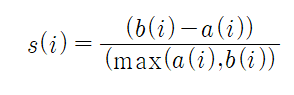

- a(i): 해당 데이터 포인트와 같은 군집 내의 다른 데이터 포인트와의 거리를 평균한 값

- b(i): 해당 데이터 포인트가 속하지 않은 군집 중 가장 가까운 군집과의 평균 거리

- b(i) - a(i): 두 군집 간의 거리가 얼마나 떨어져있는지

 → 이 값을 정규화하기 위해 MAX(a(i),b(i))값으로 나눈다

- 실루엣 계수는 -1에서 1사이의 값을 가진다.

- 1로 가까워질수록 근처의 군집과 더 멀리 떨어져 있다는 것이고 0에 가까울수록 근처의 군집과 가까워진다는 것이다. -값은 아예 다른 군집에 데이터 포인트가 할당됐음을 뜻한다.


**사이킷런 메서드**

- sklearn.metrics.silhouette_samples(X, labels, metric='euclidean', **kwds): 인자로 피처 데이터셋과 각 피처 데이터셋이 속한 군집 레이블값인 labels 데이터를 입력해주면 각 데이터 포인트의 실루엣 계수를 계산해 반환한다.

- sklearn,metrics.silhouette_score(X, labels, metric='euclidean', sample_size=None, **kwds): 전체 데이터의 실루엣 계수값을 평균하여 반환한다. 즉, np.mean(silhouette_samples()이다. 값이 높을수록 군집화가 어느정도 잘됐다고 판단할 수 있다.

**좋은 군집화가 되기 위한 조건**

1. 전체 실루엣 계수의 평균값, silhouette_score()값이 1에 가까울수록 좋다.

2. 전체 실루엣 계수의 평균값과 더불어 개별 군집의 평균값 편차가 크지 않아야 한다. 즉, 개별 군집의 실루엣 계수 평균값이 전체 실루엣 계수의 평균값에서 크게 벗어나지 않는 것이 중요하다.

#### iris 데이터를 이용한 군집 평가

In [1]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
iris_df = pd.DataFrame(data=iris.data, columns=feature_names)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris_df)
iris_df['cluster'] = kmeans.labels_

#iris 데이터의 모든 개별 데이터에 실루엣 계수값을 구함
score_samples = silhouette_samples(iris.data, iris_df['cluster'])
print('silhouette_samples() return값의 shape', score_samples.shape)

#iris_df에 실루엣 계수 칼럼 추가
iris_df['silhouette_coeff'] = score_samples

#모든 데이터의 평균 실루엣 계수값을 구함
average_score = silhouette_score(iris.data, iris_df['cluster'])
print('iris 데이터셋 Silhouette Analysis Score:{0:.3f}'.format(average_score))
iris_df.head(3)

silhouette_samples() return값의 shape (150,)
iris 데이터셋 Silhouette Analysis Score:0.553


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,1,0.852955
1,4.9,3.0,1.4,0.2,1,0.815495
2,4.7,3.2,1.3,0.2,1,0.829315


iris 데이터의 평균 실루엣 계수값은 약 0.553이다.

1번 군집의 경우 평균적으로 약 0.8정도의 높은 실루엣 계수값을 나타낸다.

그러나, 다른 군집의 실루엣 계수가 낮기 때문에 전체 평균이 0.553이 나온 것이다.

→ 군집 칼럼별로 groupby하여 silhouette_coeff의 평균을 구해보자

In [2]:
iris_df.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.417320
1    0.798140
2    0.451105
Name: silhouette_coeff, dtype: float64

0번과 2번은 1번 군집에 비해 실루엣 계수 평균값이 상대적으로 낮다.

#### 군집별 평균 실루엣 계수의 시각화를 통한 군집 개수 최적화 방법

- 전체 데이터의 평균 실루엣 계수값이 높다고 해서 반드시 최적의 개수로 군집화가 됐다고 볼 순 없다.

- 특정 군집의 계수값만 높고, 다른 군집은 내부 데이터끼리 거리가 너무 떨어져있어 계수값이 낮아져도 평균은 높아질 수 있기 때문이다.

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5662344175321901
For n_clusters = 6 The average silhouette_score is : 0.4358297989156284


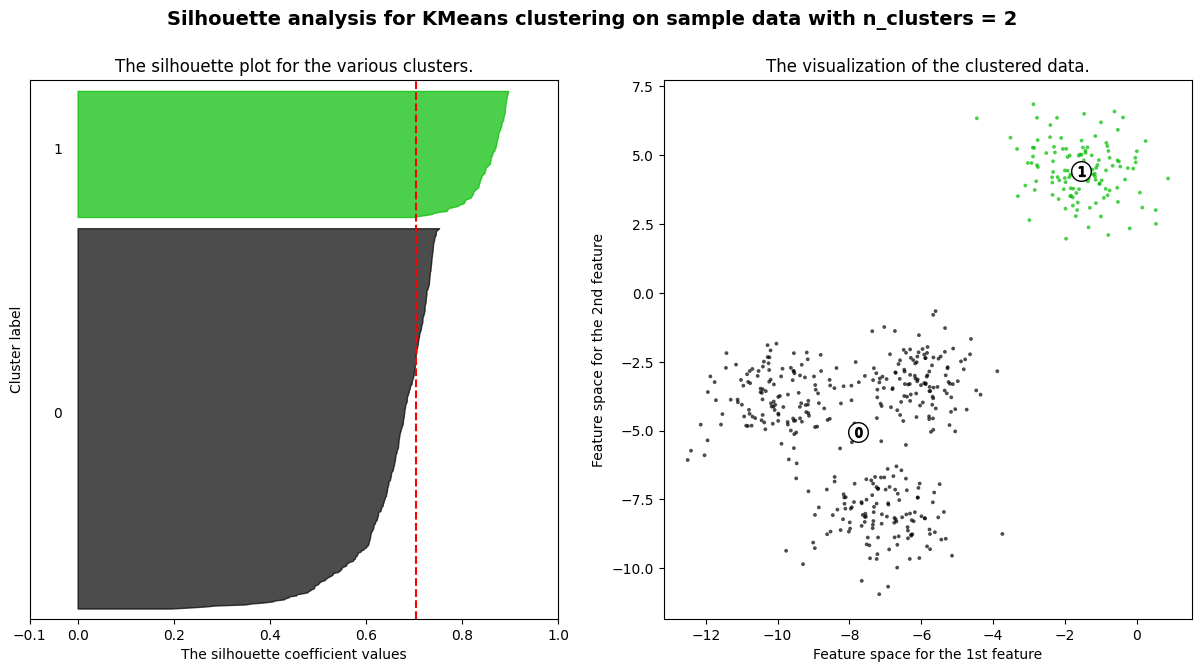

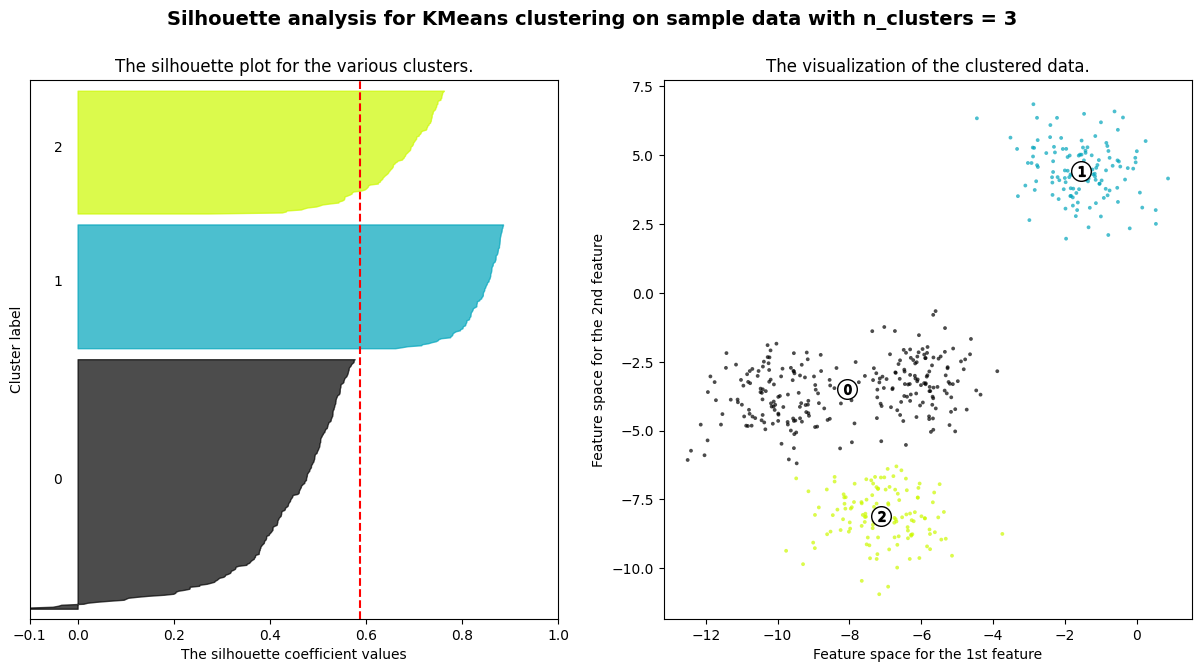

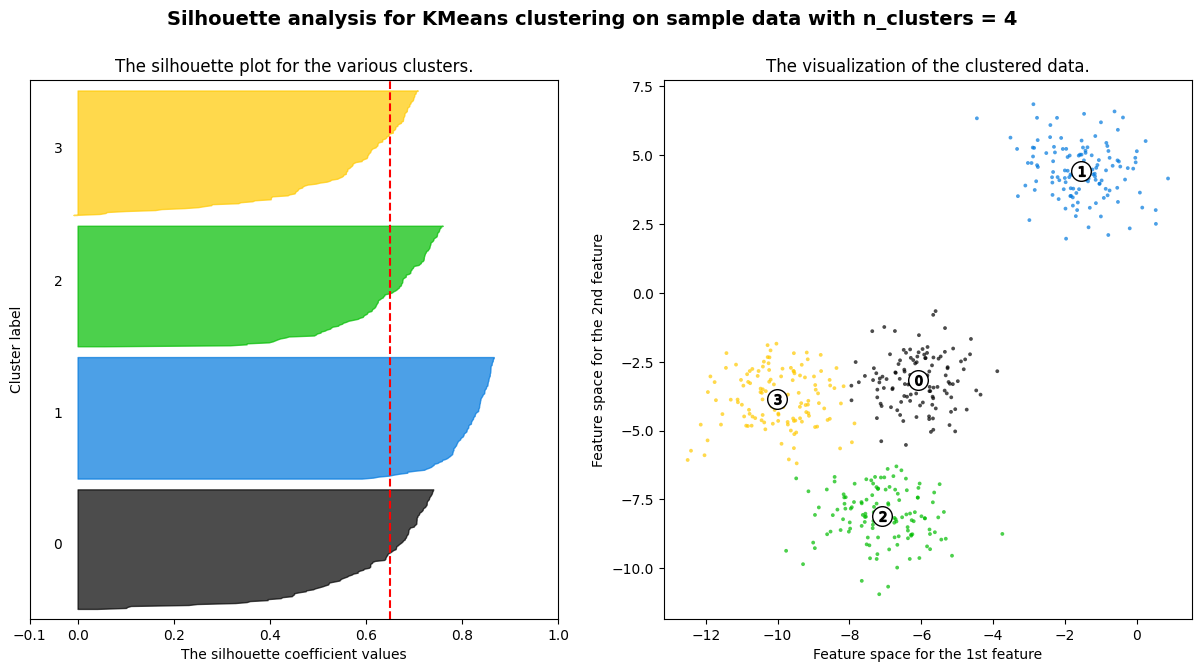

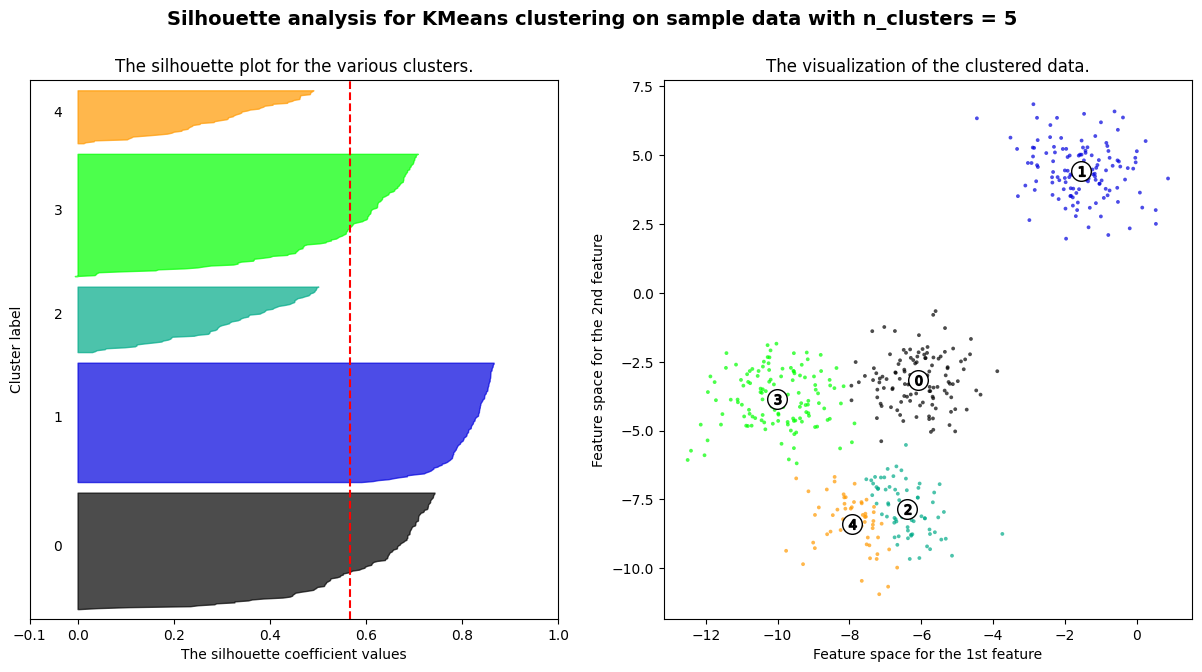

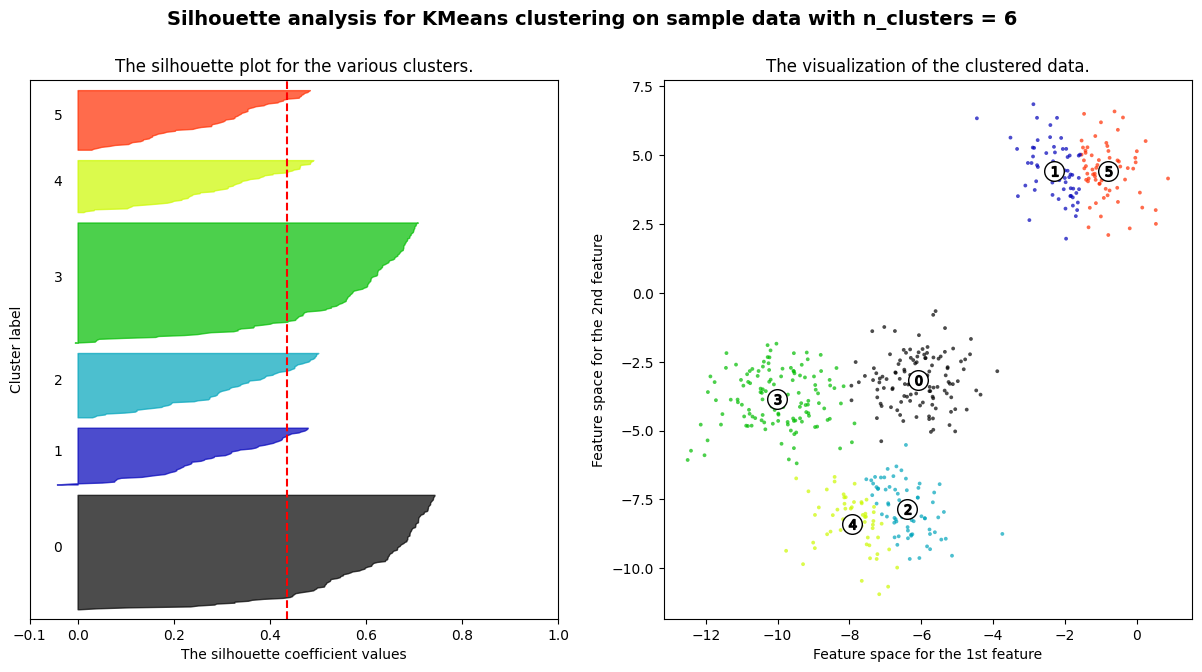

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

- 군집이 2개일 경우, silhouette_score는 0.704이다. 1번 군집의 모든 데이터는 평균 실루엣 계수값 이상이고 내부 데이터끼리 잘 뭉쳐져있지만, 0번 군집은 평균 실루엣 계수값 이하인 데이터가 많고 내부 데이터끼리도 떨어져있는 모습이다.

- 군집이 3개일 경우, silhouette_score는 0.588이다. 1, 2번 군집의 경우 평군보다 높은 실루엣 계수값을 가지지만 0번의 경우 모두 평균보다 낮고 내부 데이터 간의 거리도 멀다.

- 군집이 4개인 경우, silhouette_score는 0.65이다. 개별 군집의 평균 실루엣 계수값이 비교적 균일하게 위치한다. 1번 군집의 경우 모든 데이터가 평균보다 높은 계수값을 가지고 0, 2번의 경우는 절반 이상이 평균보다 높은 계수값, 3번의 경우는 1/3 정도가 평균보다 높은 계수값을 가진다.

  → 군집이 2개일 때보다는 평균 실루엣 계수값이 작지만 4개인 경우가 가장 이상적인 군집화 개수로 판단할 수 있다.

https://github.com/wikibook/pymldg-rev/blob/master/7%EC%9E%A5/7-2_Cluster%20evaluation.ipynb

In [4]:
#왼쪽 그림의 군집별 평균 실루엣 계수값을 구하는 부분을 별도의 함수로 만들어서 시각화하기
## 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

make_blobs()을 통해 4개 군집 중심의 500개 2차원 데이터셋을 만들고 이를 k-means로 군집화할 때 2, 3, 4, 5개 중 최적의 군집 개수를 시각화하자

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


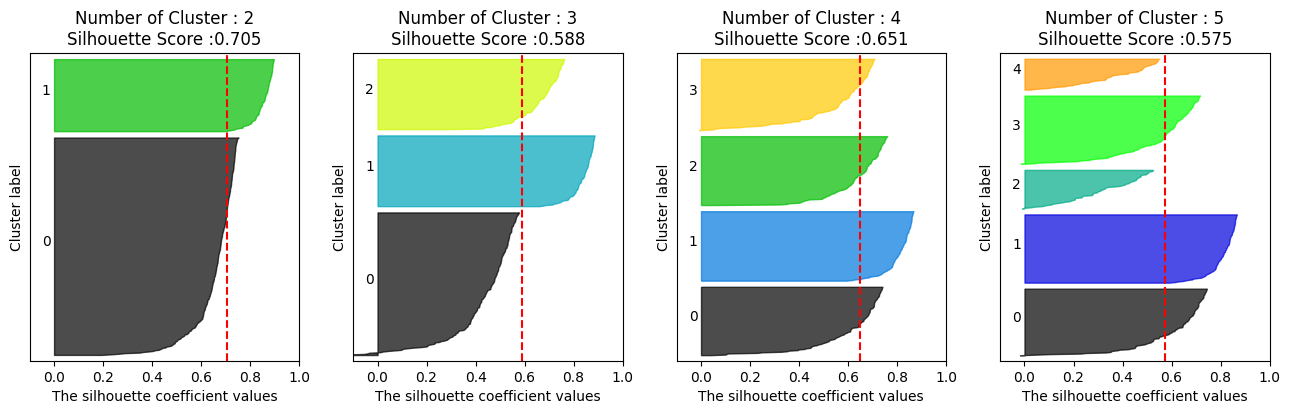

In [5]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1,
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)

visualize_silhouette([2, 3, 4, 5], X)

4개일 때가 가장 최적임을 알 수 있다.

이번엔 iris 데이터를 이용해 k-means 수행 시 최적의 군집 개수를 알아보자

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


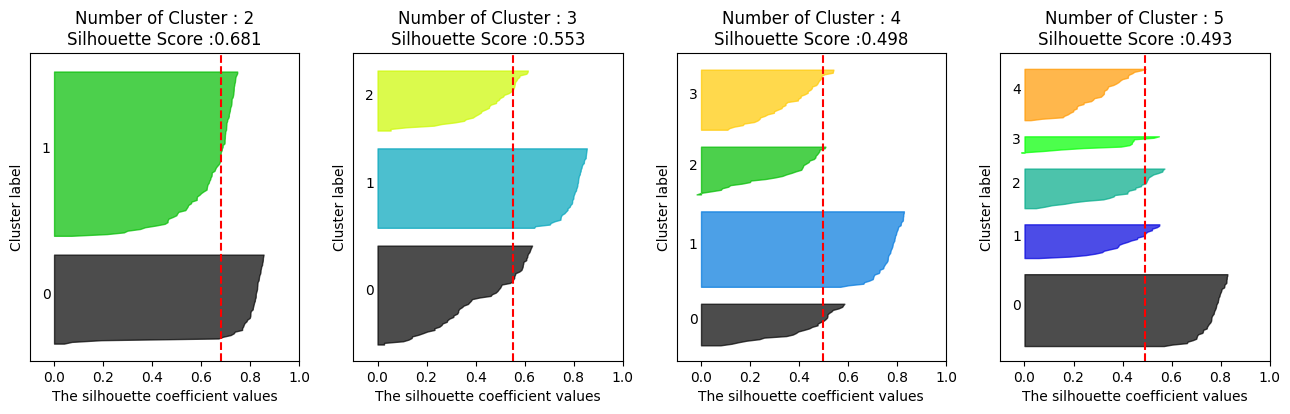

In [6]:
from sklearn.datasets import load_iris
iris = load_iris()
visualize_silhouette([2,3,4,5], iris.data)

iris 데이터를 k-means로 군집화할 경우에는 군집 개수를 2개로 하는 것이 가장 좋아보인다.

- 실루엣 계수를 통한 k-means 군집 평가 방법은 직관적으로 이해하기 쉽지만, 각 데이터별로 다른 데이터와의 거리를 반복적으로 계산해야하므로 데이터양이 늘어나면 수행 시간이 크게 늘어난다.

- 이런 경우 군집별로 임의의 데이터를 샘플링해 실루엣 계수를 평가하는 방안을 고민해야 한다.